In [1]:
import chess
import chess.pgn
import numpy as np
import matplotlib.pyplot as plt
import io
import sys, os
sys.path.insert(0,'../')
from DeepCrazyhouse.configs.main_config import main_config
import pandas as pd

In [ ]:
# unused and not working cell
content = pgn.read()  # read the pgn content into a string
nb_games = content.count("[Result")
all_games = content.split("[Event ")  # split the content for each single game

for idx, _ in enumerate(all_games):
    all_games[idx] = "[Event " + all_games[idx]

pgns = []
del all_games[0]
for game in games:
    game_start_char = game.find("1. ")
    if game_start_char != -1:
        if game[:game_start_char].find('Variant "Chess960"'):
            # 2019-09-28: fix for chess960 because in the default position lichess denotes FEN as "?"
            game = game.replace('[FEN "?"]', '[FEN "rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w KQkq - 0 1"]')

        pgns.append(io.StringIO(game))

elos = list()

for game_pgn in pgns:
    # we need to create a deep copy, otherwise the end of the file is reached for later
    game_pgn_copy = deepcopy(game_pgn)
    for _, headers in chess.pgn.scan_headers(game_pgn_copy):
        try:
            white_elo = headers["WhiteElo"]
        except KeyError:
            white_elo = "0"
        try:
            black_elo = headers["BlackElo"]
        except KeyError:
            black_elo = "0"
        elos.append(int(white_elo))
        elos.append(int(black_elo))

In [2]:
use960 = True
dataset = "train"
prefix = "960_" if use960 else ""

import_dir = f"C:/workspace/Python/CrazyAra/data/chess960_pgns/pgn/{dataset}/" if use960 else f"C:/workspace/Python/CrazyAra/data/kingbase2019_lite_pgn_months/pgn/{dataset}/"
pgn_filenames = os.listdir(import_dir)

chosen_file = import_dir + pgn_filenames[-1]
pgn = open(chosen_file, "r")
chosen_file

'C:/workspace/Python/CrazyAra/data/chess960_pgns/pgn/train/lichess_db_chess960_rated_2023-11.pgn'

In [3]:
games_parsed = 0
elos = list()
elo_dict = dict()

while True:
    curr_game = chess.pgn.read_game(pgn)
    games_parsed += 1
    if games_parsed % 10000 == 0:
        print(games_parsed)
    if curr_game is None or games_parsed > 1000000:
        break

    try:
        white_elo = curr_game.headers["WhiteElo"]
        white_name = curr_game.headers["White"]
    except KeyError:
        white_elo = "0"
        white_name = "None"
    try:
        black_elo = curr_game.headers["BlackElo"]
        black_name = curr_game.headers["Black"]
    except KeyError:
        black_elo = "0"
        black_name = "None"
    elos.append(int(white_elo))
    elos.append(int(black_elo))
    elo_dict[white_name] = int(white_elo)
    elo_dict[black_name] = int(black_elo)
    #_, headers = chess.pgn.scan_headers(game_pgn_copy)

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000


In [4]:
np.mean(elos)

1773.386099737731

<Axes: >

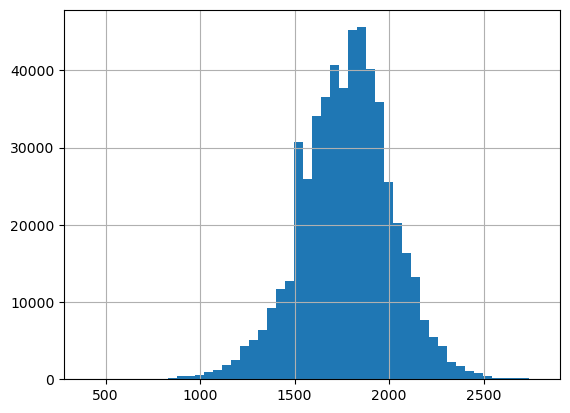

In [5]:
import pandas as pd
pd_elos = pd.Series(elos)
pd_elos.hist(bins=50)

In [6]:
np.median(elos)

1785.0

In [17]:
sorted_values_unique = list(elo_dict.values())
sorted_values_unique = sorted([rating for rating in sorted_values_unique if rating != 1500])
np.mean(sorted_values_unique)

1581.2894903593735

In [18]:
np.median(sorted_values_unique)

1583.0

<Axes: >

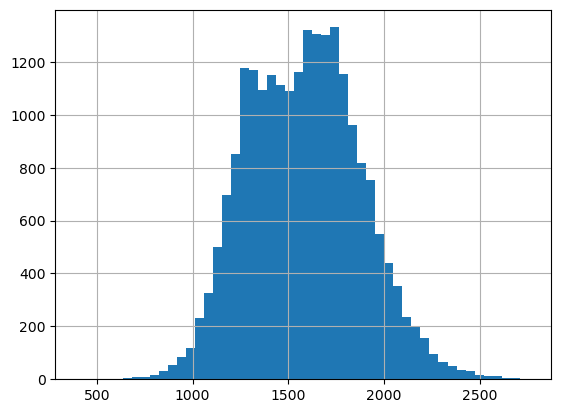

In [19]:
pd_elos = pd.Series(sorted_values_unique)
pd_elos.hist(bins=50)

In [20]:
len(sorted_values_unique)

22094

In [21]:
sorted_values_unique[:10]

[400, 571, 613, 646, 657, 678, 686, 688, 691, 712]

In [25]:
sorted_values_unique[-2300]

1952

In [2]:
pgn = open(f"C:/workspace/Python/CrazyAra/etc/2023-champions-chess-tour-finals-round-robin-stage.pgn", "r")

games_parsed = 0
elos = list()
elo_dict = dict()
player_results_dict = dict()
result_to_white_points = {"1-0": 1, "0-1": 0, "1/2-1/2": 0.5}
tie_results_to_white_points = {"1-0": 1, "0-1": 0, "1/2-1/2": 0}

while True:
    curr_game = chess.pgn.read_game(pgn)
    games_parsed += 1
    if games_parsed % 10000 == 0:
        print(games_parsed)
    if curr_game is None or games_parsed > 1000000:
        break

    try:
        white_elo = curr_game.headers["WhiteElo"]
        white_name = curr_game.headers["White"]
        round = curr_game.headers["Round"]
        result = curr_game.headers["Result"]
        black_elo = curr_game.headers["BlackElo"]
        black_name = curr_game.headers["Black"]
    except KeyError:
        white_elo = "0"
        white_name = "None"
        round = ""
        result = ""
        black_elo = "0"
        black_name = "None"

    is_tiebreaker_game = (round[-1] == "3")
    tie_points_white = tie_results_to_white_points[result] if is_tiebreaker_game else 0
    tie_points_black = 1-tie_points_white if is_tiebreaker_game else 0
    

    points_white = result_to_white_points[result] if not is_tiebreaker_game else 0
    points_black = 1-points_white if not is_tiebreaker_game else 0

    print(round, points_white, points_black, tie_points_white, tie_points_black)
    
    if white_name not in player_results_dict:
        player_results_dict[white_name] = [points_white, points_black, tie_points_white, tie_points_black, -0.5+tie_points_white if is_tiebreaker_game else 0, -0.5+tie_points_black if is_tiebreaker_game else 0]
    else:
        player_results_dict[white_name][0] += points_white
        player_results_dict[white_name][1] += points_black
        player_results_dict[white_name][2] += tie_points_white
        player_results_dict[white_name][3] += tie_points_black
        player_results_dict[white_name][4] += (-0.5+tie_points_white) if is_tiebreaker_game else 0
        player_results_dict[white_name][5] += (-0.5+tie_points_black) if is_tiebreaker_game else 0

    if black_name not in player_results_dict:
        player_results_dict[black_name] = [points_black, points_white, tie_points_black, tie_points_white, -0.5+tie_points_black if is_tiebreaker_game else 0, -0.5+tie_points_white if is_tiebreaker_game else 0]
    else:
        player_results_dict[black_name][0] += points_black
        player_results_dict[black_name][1] += points_white
        player_results_dict[black_name][2] += tie_points_black
        player_results_dict[black_name][3] += tie_points_white
        player_results_dict[black_name][4] += (-0.5+tie_points_black) if is_tiebreaker_game else 0
        player_results_dict[black_name][5] += (-0.5+tie_points_white) if is_tiebreaker_game else 0
    
    elos.append(int(white_elo))
    elos.append(int(black_elo))
    elo_dict[white_name] = int(white_elo)
    elo_dict[black_name] = int(black_elo)
    #_, headers = chess.pgn.scan_headers(game_pgn_copy)

1.1 0.5 0.5 0 0
1.1 1 0 0 0
1.1 0 1 0 0
1.1 1 0 0 0
1.2 1 0 0 0
1.2 0.5 0.5 0 0
1.2 0.5 0.5 0 0
1.2 1 0 0 0
1.3 0 0 0 1
2.1 1 0 0 0
2.1 0.5 0.5 0 0
2.1 0 1 0 0
2.1 0.5 0.5 0 0
2.2 0.5 0.5 0 0
2.2 0.5 0.5 0 0
2.2 0 1 0 0
2.2 0.5 0.5 0 0
2.3 0 0 1 0
2.3 0 0 0 1
2.3 0 0 1 0
3.1 0 1 0 0
3.1 0.5 0.5 0 0
3.1 0.5 0.5 0 0
3.1 1 0 0 0
3.2 0 1 0 0
3.2 0 1 0 0
3.2 0.5 0.5 0 0
3.2 0 1 0 0
3.3 0 0 0 1
3.3 0 0 1 0
4.1 1 0 0 0
4.1 0.5 0.5 0 0
4.1 0.5 0.5 0 0
4.1 0.5 0.5 0 0
4.2 0 1 0 0
4.2 0.5 0.5 0 0
4.2 0.5 0.5 0 0
4.2 0.5 0.5 0 0
4.3 0 0 1 0
4.3 0 0 1 0
4.3 0 0 1 0
5.1 1 0 0 0
5.1 0 1 0 0
5.1 1 0 0 0
5.1 0.5 0.5 0 0
5.2 0.5 0.5 0 0
5.2 0 1 0 0
5.2 0.5 0.5 0 0
5.2 0.5 0.5 0 0
5.3 0 0 1 0
5.3 0 0 1 0
6.1 0.5 0.5 0 0
6.1 0.5 0.5 0 0
6.1 1 0 0 0
6.1 0.5 0.5 0 0
6.2 0.5 0.5 0 0
6.2 0.5 0.5 0 0
6.2 0.5 0.5 0 0
6.2 0.5 0.5 0 0
6.3 0 0 1 0
6.3 0 0 0 1
6.3 0 0 0 1
7.1 0.5 0.5 0 0
7.1 1 0 0 0
7.1 0.5 0.5 0 0
7.1 0 1 0 0
7.2 0.5 0.5 0 0
7.2 0 1 0 0
7.2 0.5 0.5 0 0
7.2 0 1 0 0
7.3 0 0 0 1
7.3 0 0 1 0
7.3 0 0 

In [3]:
player_results_dict

{'Abdusattorov, Nodirbek': [7.5, 6.5, 3, 2, 0.5, -0.5],
 'Firouzja, Alireza': [6.0, 8.0, 1, 3, -1.0, 1.0],
 'Carlsen, Magnus': [8.5, 5.5, 3, 1, 1.0, -1.0],
 'Lazavik, Denis': [4.5, 9.5, 1, 2, -0.5, 0.5],
 'Nakamura, Hikaru': [8.5, 5.5, 0, 4, -2.0, 2.0],
 'So, Wesley': [8.0, 6.0, 4, 1, 1.5, -1.5],
 'Caruana, Fabiano': [6.0, 8.0, 4, 0, 2.0, -2.0],
 'Vachier-Lagrave, Maxime': [7.0, 7.0, 1, 4, -1.5, 1.5]}

In [4]:
for player in player_results_dict.keys():
    player_results_dict[player].append(player_results_dict[player][0]+player_results_dict[player][2]-player_results_dict[player][1]-player_results_dict[player][3])
    player_results_dict[player].append(player_results_dict[player][0]+player_results_dict[player][4]-player_results_dict[player][1]-player_results_dict[player][5])

In [5]:
player_results_dict

{'Abdusattorov, Nodirbek': [7.5, 6.5, 3, 2, 0.5, -0.5, 2.0, 2.0],
 'Firouzja, Alireza': [6.0, 8.0, 1, 3, -1.0, 1.0, -4.0, -4.0],
 'Carlsen, Magnus': [8.5, 5.5, 3, 1, 1.0, -1.0, 5.0, 5.0],
 'Lazavik, Denis': [4.5, 9.5, 1, 2, -0.5, 0.5, -6.0, -6.0],
 'Nakamura, Hikaru': [8.5, 5.5, 0, 4, -2.0, 2.0, -1.0, -1.0],
 'So, Wesley': [8.0, 6.0, 4, 1, 1.5, -1.5, 5.0, 5.0],
 'Caruana, Fabiano': [6.0, 8.0, 4, 0, 2.0, -2.0, 2.0, 2.0],
 'Vachier-Lagrave, Maxime': [7.0, 7.0, 1, 4, -1.5, 1.5, -3.0, -3.0]}